<a href="https://colab.research.google.com/github/dlarsson2000/ML4BiotechProject/blob/main/CB206V_ex_8_CNNS_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## exercise - convolutional neural network for a spatial cell problem
The following artificial dataset is a simulation of a tissue slice where we can think of each point in a 16x16 array as an individual cell. Each cell has 6 genes that we are keeping track of and which have a binary format, i.e. they are either on (1) or off (0). Then there is a status class label, in which we have designated each cell as either cancerous or healthy. The goal of the exercise is to build a convolutional neural network that models the class variable by predicting it from gene expression features. The data have been constructed in such a way as to hide these features to be difficult for linear models to find. But moreover, the cancer tends to cluster into the form of tumors, and thus local spatial correlations should contribute to our ability to predict its location.

### download the dataset
after running the cell below, you can click the folder icon to the right and see if the .csv file is there now. Feel free to look at it and what is in it.

In [ ]:
import requests
def download_from_github(url, filename):
    response = requests.get(url)
    with open(filename, 'wb') as file:
        file.write(response.content)
url = 'https://raw.githubusercontent.com/Intertangler/ML4biotech/main/all_tissue_slices.csv'
filename = 'all_tissue_slices.csv'
download_from_github(url, filename)


### load the data into variables
We will import the data into programming variables in order to handle them hereafter. We will make use of a reverse lookup table which will be for mapping rectangular matrix indices back to the hexagonal lattice coordinates of the cell positions. Also note how gene expression values (1's and 0's) are stored in the "lattice" variable.

In [ ]:
import pandas as pd

def load_slices_from_csv(n_genes, filename='all_tissue_slices.csv'):
    df = pd.read_csv(filename)
    all_slices = {}

    # we group by slice id
    grouped = df.groupby('Tissue_Slice_ID')

    for name, group in grouped:
        lattice = {}
        cancer_status = {}
        effector_status = {}
        pathology_counter = {}
        reverse_lookup = {}  # reverse lookup to remap back to hex coordinates
        for _, row in group.iterrows():
            x, y = float(row['x']), float(row['y'])
            row_idx, col_idx = int(row['row_idx']), int(row['col_idx'])  # extract row and col indexes
            is_cancer = row['is_cancer']
            is_effector = row['is_effector']
            genes = list(row[['gene_{}'.format(i) for i in range(1, n_genes+1)]])
            pathology = row['pathology_counter']

            # fill variables with data for this slice
            lattice[(x, y)] = genes
            cancer_status[(x, y)] = is_cancer
            effector_status[(x, y)] = is_effector
            pathology_counter[(x, y)] = pathology
            reverse_lookup[(x, y)] = (row_idx, col_idx)  # update reverse_lookup w data

        # Store the reconstructed data for this slice in 'all_slices'
        all_slices[name] = {
            'lattice': lattice,
            'cancer_status': cancer_status,
            'effector_status': effector_status,
            'pathology_counter': pathology_counter,
            'reverse_lookup': reverse_lookup
        }

    return all_slices


# Load the data
all_slices = load_slices_from_csv(n_genes = 6)



### visualize some of the slices
Below we can visualize the class labels (healthy and cancerous) - there is a third one called effector which we will ignore.

Then we have a "pathology counter" which is actually a hidden variable computed from the artificially rigged interactions between nearby cells. This variable is correlated to the cancer status of each cell. But we do not have direct access to it from the gene expression data alone.

Then lastly, we have the gene expression data visualized using RGB. Although there are 6 genes, the first 3 have been mapped to rgb colors. So a cell colored magenta would indicate, for example, that the cell expresses 2 out of 3 of the genes being plotted (i.e. a combination of red and blue). A white colored cell expresses all 3, and black expresses none.

Try examining some of the slices to see if you discern any visual pattern in the raw gene expression data corresponding to the ground truth class variable.



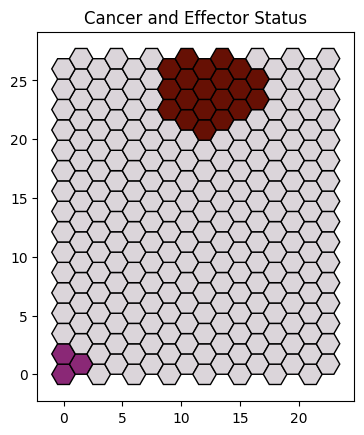

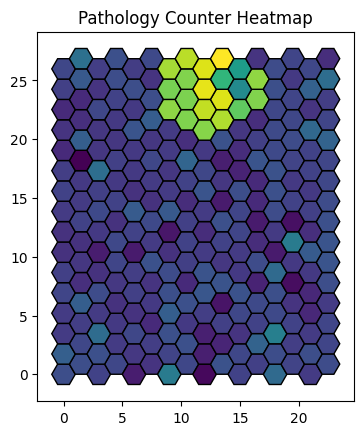

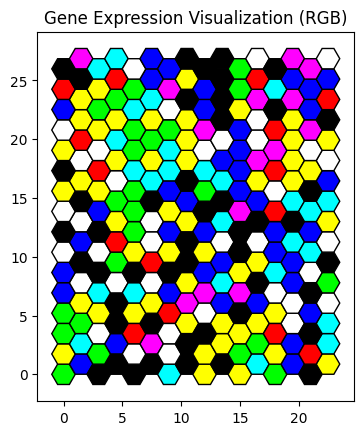

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
import itertools
import random
import math
def visualize_slice_ground_truth(radius,cancer_status,effector_status,lattice):
    fig, ax1 = plt.subplots()
    ax1.set_aspect('equal')
    for (x, y), genes in lattice.items():
        if cancer_status[(x, y)]:  # Cancer cells
            color = '#661004'
        elif effector_status.get((x, y), False):  # Effector cells
            color = '#8a2876'
        else:
            color = '#dbd5da'  # Normal cells
        hexagon = RegularPolygon((x, y), numVertices=6, radius=radius, orientation=np.pi/6, facecolor=color, edgecolor='black')
        ax1.add_patch(hexagon)
    ax1.autoscale_view()
    plt.title("Cancer and Effector Status")
    plt.show()

def visualize_pathology_counter(radius, pathology_counter):
    fig, ax2 = plt.subplots()
    ax2.set_aspect('equal')
    max_counter = max(pathology_counter.values())
    min_counter = min(pathology_counter.values())+.00001

    for (x, y), counter in pathology_counter.items():
        normalized_counter = (counter - min_counter) / (max_counter - min_counter)
        color = plt.cm.viridis(normalized_counter)
        hexagon = RegularPolygon((x, y), numVertices=6, radius=radius, orientation=np.pi/6, facecolor=color, edgecolor='black')
        ax2.add_patch(hexagon)

    ax2.autoscale_view()
    plt.title("Pathology Counter Heatmap")
    plt.show()

def visualize_gene_expression(radius, lattice):
    fig, ax3 = plt.subplots()
    ax3.set_aspect('equal')
    def normalize_gene_value(gene_value):
        return np.clip(gene_value, 0, 1)
    for (x, y), genes in lattice.items():
        r = normalize_gene_value(genes[0])
        g = normalize_gene_value(genes[1])
        b = normalize_gene_value(genes[2])
        color = (r, g, b)
        hexagon = RegularPolygon((x, y), numVertices=6, radius=radius, orientation=np.pi/6, facecolor=color, edgecolor='black')
        ax3.add_patch(hexagon)
    ax3.autoscale_view()
    plt.title("Gene Expression Visualization (RGB)")
    plt.show()


# example slice
slice_1_data = all_slices.get('slice_1', {})
reverse_lookup = slice_1_data.get('reverse_lookup', {})
lattice = slice_1_data.get('lattice', {})
cancer_status = slice_1_data.get('cancer_status', {})
effector_status = slice_1_data.get('effector_status', {})
pathology_counter = slice_1_data.get('pathology_counter', {})


visualize_slice_ground_truth(1, cancer_status, effector_status,lattice)
visualize_pathology_counter(1, pathology_counter)
visualize_gene_expression(1, lattice)

### functions for preparing the data as cnn input
these functions will be used to import the data and format it as a matrix appropriate as the input to the cnn

In [ ]:
import numpy as np
import csv
from sklearn.model_selection import train_test_split
def lattice_to_cnn_input(lattice, reverse_lookup, dims=(16,16), n_genes=6):
    cnn_input = np.zeros((dims[0], dims[1], n_genes))
    for (x, y), genes in lattice.items():
        row_idx, col_idx = reverse_lookup[(x, y)]
        cnn_input[row_idx, col_idx] = genes
    return cnn_input

def csv_to_lattices_and_labels(filename, dims=(16, 16)):
    with open(filename, 'r') as f:
        reader = csv.reader(f)
        next(reader)
        rows = list(reader)
    lattices = {}
    reverse_lookups = {}
    labels = {}
    for row in rows:
        tissue_slice_id, x, y, row_idx, col_idx, is_cancer, is_effector, *genes, pathology_counter = row
        x, y = float(x), float(y)
        row_idx, col_idx = int(row_idx), int(col_idx)
        if tissue_slice_id not in lattices:
            lattices[tissue_slice_id] = {}
            reverse_lookups[tissue_slice_id] = {}
            labels[tissue_slice_id] = np.zeros(dims)
        genes = [float(g) for g in genes]
        lattices[tissue_slice_id][(x, y)] = genes
        reverse_lookups[tissue_slice_id][(x, y)] = (row_idx, col_idx)
        labels[tissue_slice_id][row_idx, col_idx] = 1.0 if is_cancer.lower() == 'true' else 0.0
    lattices_array = np.array([lattice_to_cnn_input(lattices[key], reverse_lookups[key]) for key in sorted(lattices.keys())])
    labels_array = np.array([labels[key] for key in sorted(labels.keys())])
    return lattices_array, labels_array


## exercise part - build the cnn architecture
Using your experience from the previous exercises in which we have used Keras to contruct neural networks, set up a model including the the architecture with convolutional layers (see the documentation from Keras for how to do this https://keras.io/api/layers/convolution_layers/convolution2d/). And set up the compilation, training, and testing as we have done previously for other neural networks.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import ZeroPadding2D


# Load the data from the csv
lattices, cancer_labels = csv_to_lattices_and_labels('all_tissue_slices.csv')

# Train-test split - split the data into training and tests sets
train_data, test_data, train_labels, test_labels = train_test_split(lattices, cancer_labels, test_size=0.2, random_state=1234)

# numpy array conversion
train_data = np.array(train_data)
test_data = np.array(test_data)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

input_tensor = Input(shape=(16, 16, 6))
# add a convolutional layer here with a certain number of kernels, specify dimensions of the kernel e.g. 3x3
# remember to choose an activation function
# structure the output layer to have analogous dimensions as the input,
#i.e. a 16x16 array except instead of 6-element gene vector, a 1-element class variable
# we want the activation function for the last layer to be a sigmoid
#🌟🌟🌟🌟 YOUR CODE HERE 🌟🌟🌟🌟#

# define the model
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_tensor)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
output_tensor = Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_data, train_labels, epochs=100, batch_size=32, validation_split=0.2)

# Predict
y_pred = model.predict(test_data)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step - accuracy: 0.5894 - loss: 0.6642 - val_accuracy: 0.8853 - val_loss: 0.5030
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.8953 - loss: 0.4683 - val_accuracy: 0.8853 - val_loss: 0.3991
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8986 - loss: 0.3645 - val_accuracy: 0.8853 - val_loss: 0.3997
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.8945 - loss: 0.3640 - val_accuracy: 0.8853 - val_loss: 0.4403
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8943 - loss: 0.3933 - val_accuracy: 0.8853 - val_loss: 0.4411
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9014 - loss: 0.3682 - val_accuracy: 0.8853 - val_loss: 0.4182
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9011 - loss: 0.3539 - val_accuracy: 0.8853 - val_loss: 0.3953
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8963 - loss: 0.3548 - val_accuracy: 0.8853 - v

### verify visually
To see if the model is working, let's perform some side-by-side comparisons of the test data (cancer label) with our predicted outcome activation values.

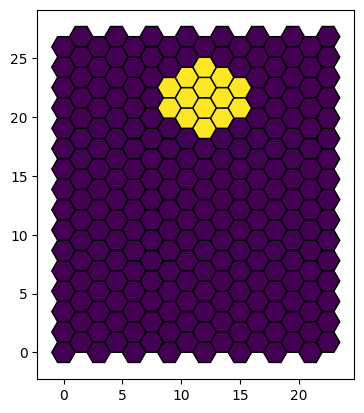

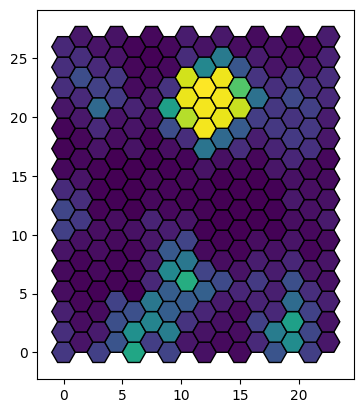

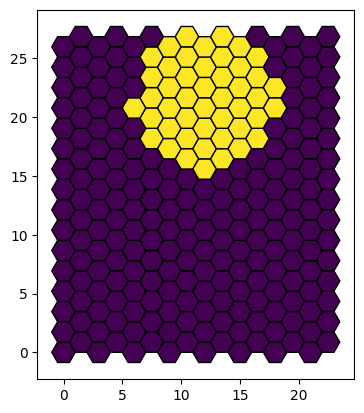

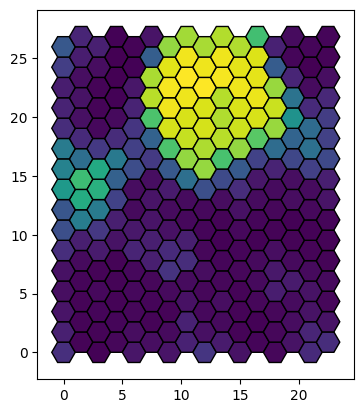

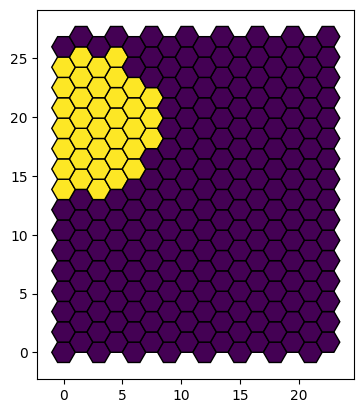

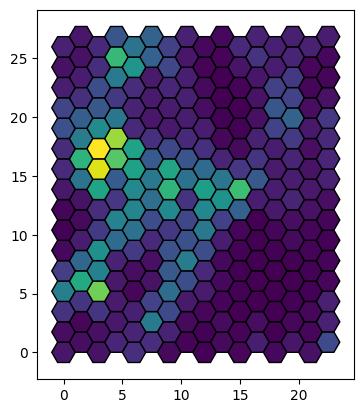

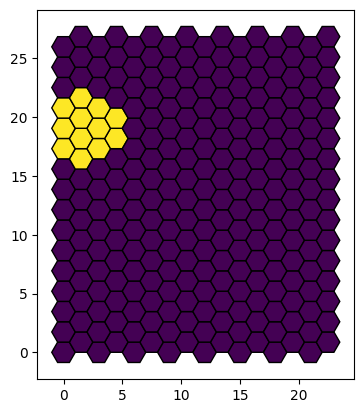

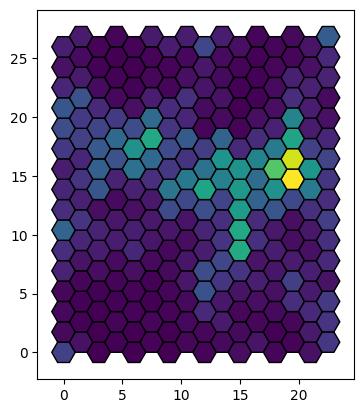

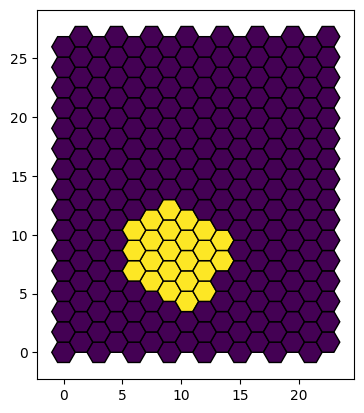

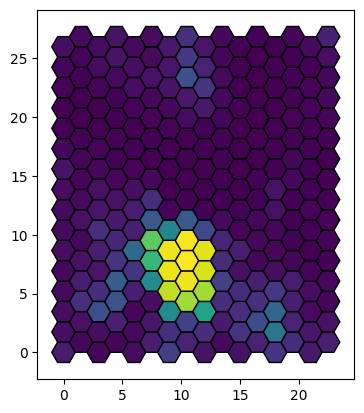

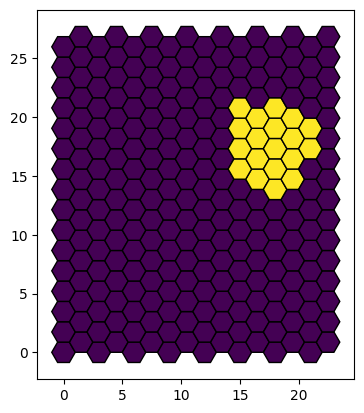

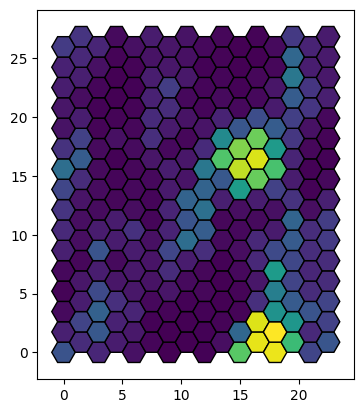

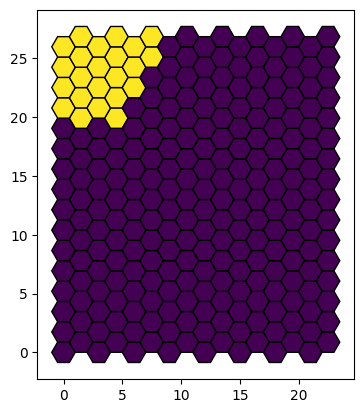

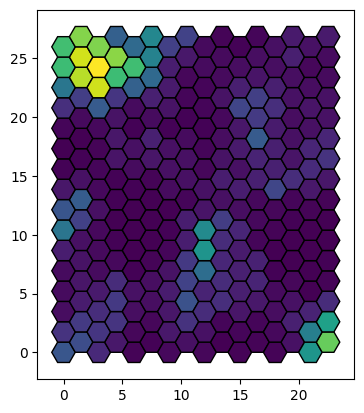

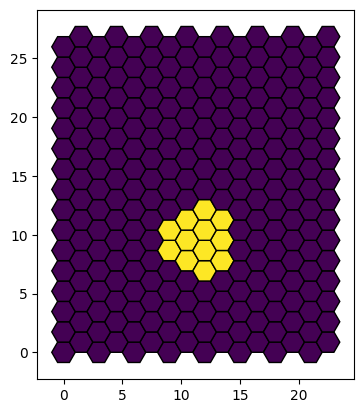

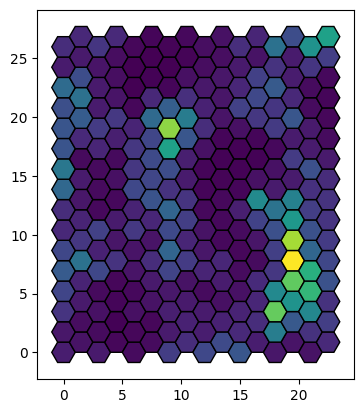

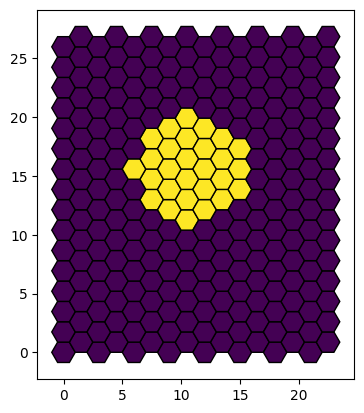

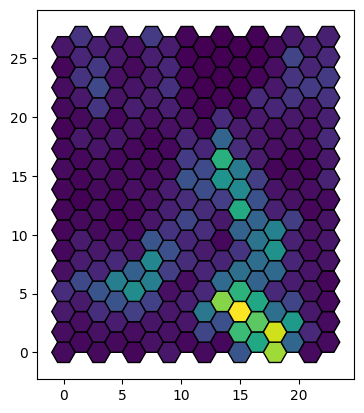

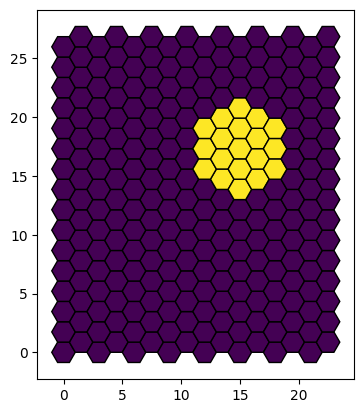

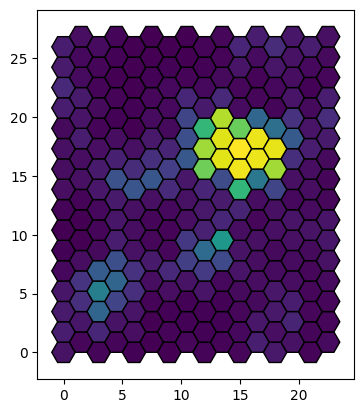

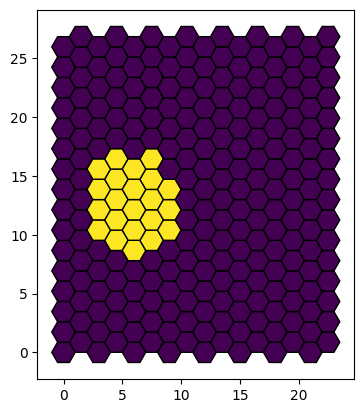

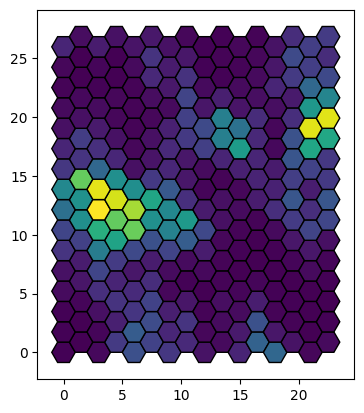

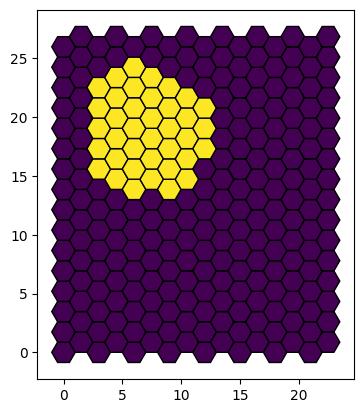

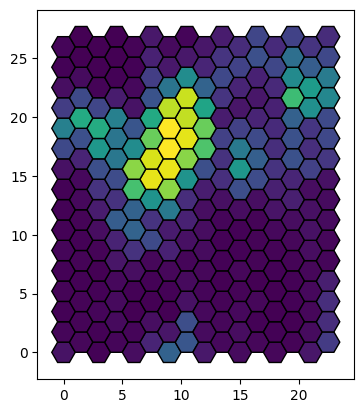

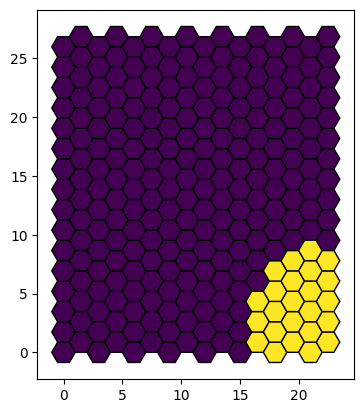

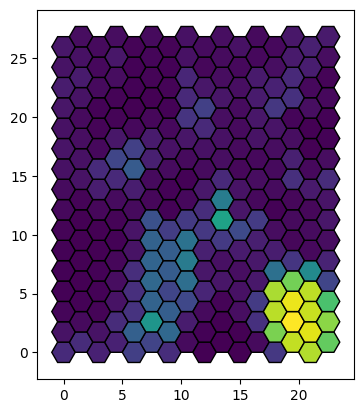

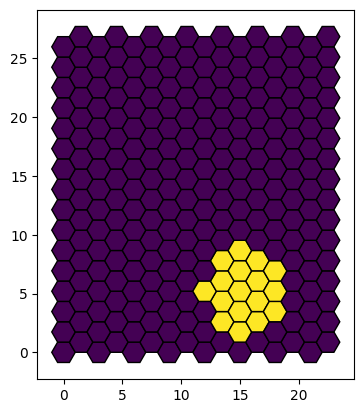

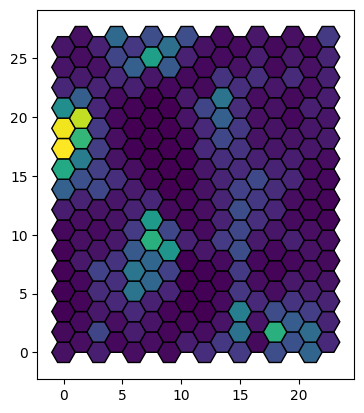

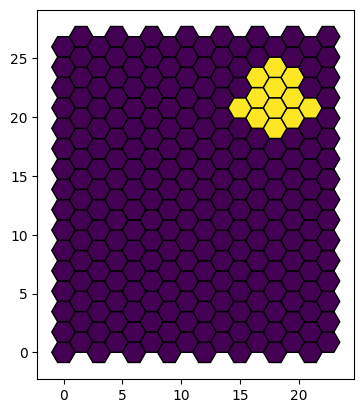

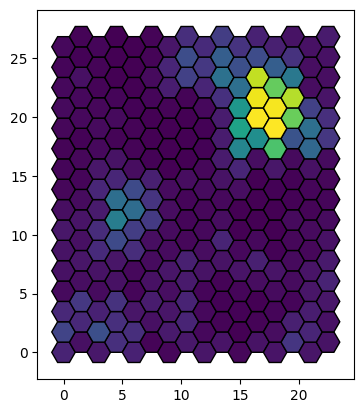

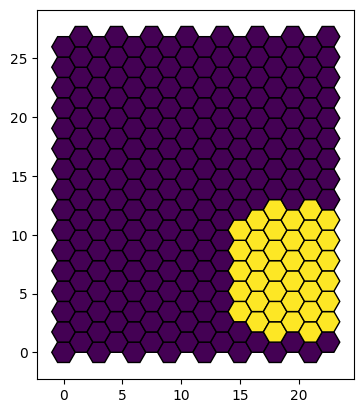

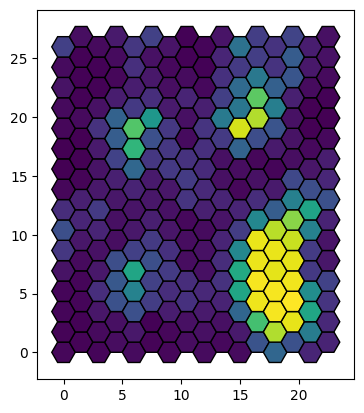

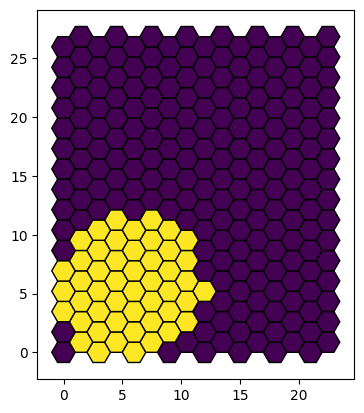

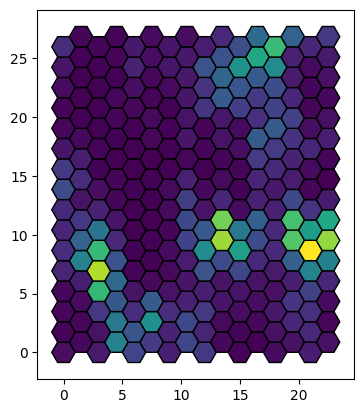

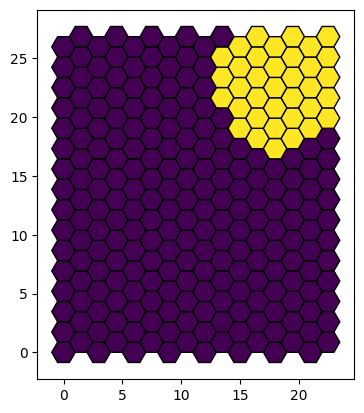

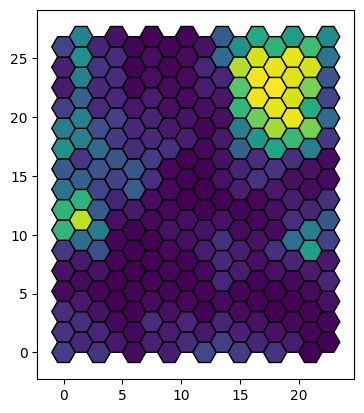

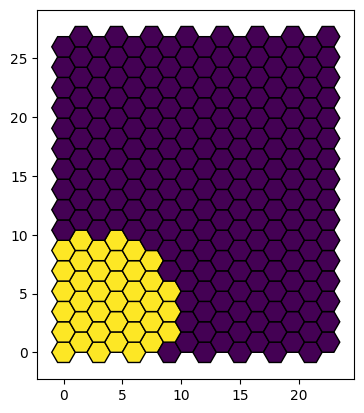

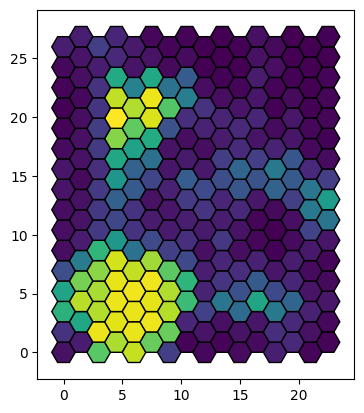

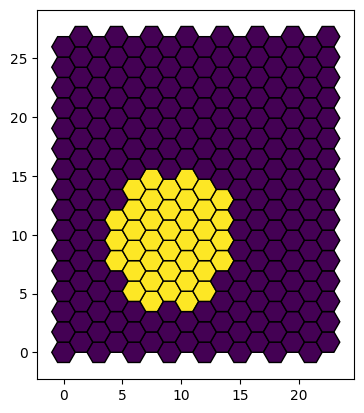

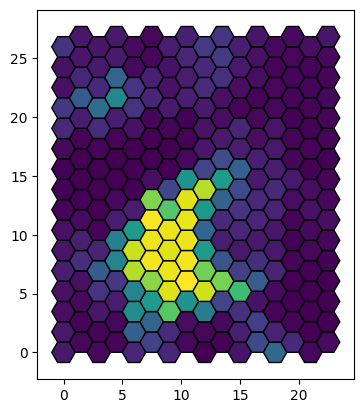

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon

def visualize_predictions(radius, predictions, dims=(16, 16)):
    pathology_counter = {}
    for row in range(dims[0]):
        for col in range(dims[1]):
            x = round(col * 1.5 * radius, 3)
            y = round(row * np.sqrt(3) * radius, 3)
            if col % 2 == 1:
                y += round(np.sqrt(3)/2 * radius, 3)
            pathology_counter[(x, y)] = predictions[row, col, 0]

    visualize_pathology_counter(radius, pathology_counter)

def visualize_pathology_counter(radius, pathology_counter):
    fig, ax2 = plt.subplots()
    ax2.set_aspect('equal')
    max_counter = max(pathology_counter.values())
    min_counter = min(pathology_counter.values())+.00001

    for (x, y), counter in pathology_counter.items():
        normalized_counter = (counter - min_counter) / (max_counter - min_counter)
        color = plt.cm.viridis(normalized_counter)
        hexagon = RegularPolygon((x, y), numVertices=6, radius=radius, orientation=np.pi/6, facecolor=color, edgecolor='black')
        ax2.add_patch(hexagon)

    ax2.autoscale_view()
    plt.show()
def visualize_test_labels(radius, test_labels, dims=(16, 16)):
    pathology_counter = {}
    for row in range(dims[0]):
        for col in range(dims[1]):
            x = round(col * 1.5 * radius, 3)
            y = round(row * np.sqrt(3) * radius, 3)
            if col % 2 == 1:
                y += round(np.sqrt(3)/2 * radius, 3)
            pathology_counter[(x, y)] = test_labels[row, col]

    visualize_pathology_counter(radius, pathology_counter)
for i in range(0, np.shape(test_data)[0]):
    visualize_test_labels(1, test_labels[i])
    visualize_predictions(1, y_pred[i])
